In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchvision.datasets import CIFAR10
import os
import torch
# To read zipped .tar, .tz file
import tarfile
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
# Below library will help us to pass batch of data, as feeding all data at once will lead to OverLoading and System will get Hang
from torch.utils.data.dataloader import DataLoader
# These libraries will help us to plot images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In computer-vision, CIFAR-10  is an established benchmark dataset used object recognition. It is a subset of 80 million tiny images. CIFAR-10 consists of $60,000$ $32\times32$ color images containing objects of one of 10 classes (with 6000 images per class). It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The classes represented in the dataset are:

* airplane 
* automobile 
* bird 
* cat 
* deer 
* dog 
* frog 
* horse 
* ship 
* truck

# Import Required Libraries and Load Data from Pytorch Dataset

Download the data from URL below

In [4]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [5]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path = './data')

Data is now in the `./data` folder

In [6]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))

classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


As displayed, we have 10 Classes, and 2 folders are available Train and Test

Let's read some of images and plot them

In [7]:
airplane_file = os.listdir(data_dir + '/train/airplane')
print('Number of Training Examples: ', len(airplane_file))
print(airplane_file[:5])

Number of Training Examples:  5000
['3975.png', '1804.png', '4968.png', '1810.png', '3961.png']


In [8]:
ship_file = os.listdir(data_dir + '/test/ship')
print('Number of Testing Examples: ', len(ship_file))
print(ship_file[:5])

Number of Testing Examples:  1000
['0298.png', '0267.png', '0501.png', '0515.png', '0273.png']


### Image Augumentation
- We have to do this job before making our model. The expectation that augmentation will prevent overfitting. This is not guaranteed and at the current stage in the class where we have not covered the topic is a dirty hack. Please treat it as such. namely - an artificial way to increase training data without relying on the unknown data generation process.

To additionally reduce the chance of overfitting, let's carry out Normalization and Regularization as below

In [39]:
trans = transforms.Compose([
    ######## ADD YOUR CODE HERE ########
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.4914,0.4822,0.4465],[0.247,0.243,0.261])
])
lambda x: x

<function __main__.<lambda>(x)>

Let's load train and test data

In [40]:
train_ds = ImageFolder(data_dir+'/train', transform = trans)
val_ds = ImageFolder(data_dir+'/test', transform = trans)

# Hyperparameters

##  Add more parameters for your code.

In [41]:
# this is one of Hyper parameter, add more parameters for your code.
batch_size = 512

In [42]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

# Plot and observe sets

In [43]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[: 100], 10).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


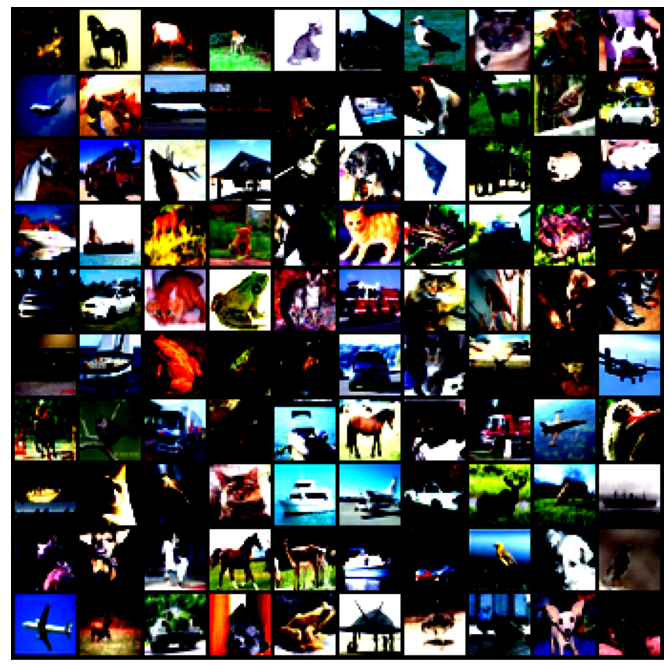

In [27]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


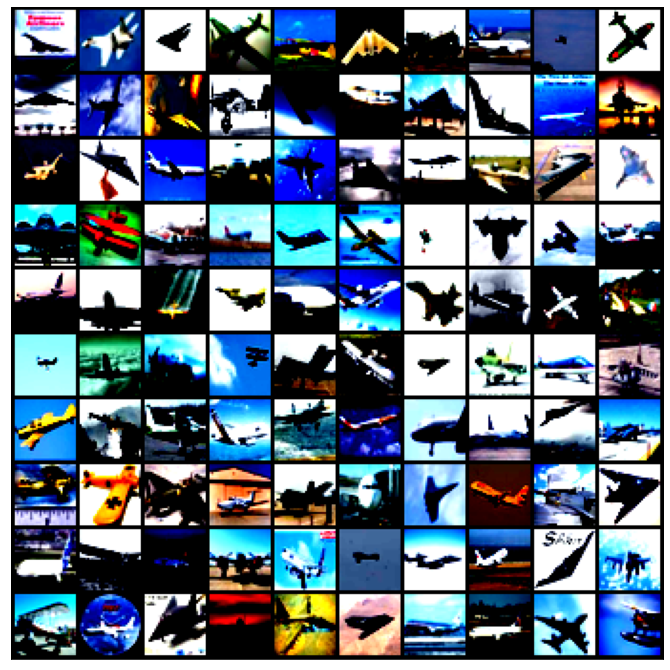

In [28]:
show_batch(valid_dl)

We can see some changes in images from original image from dataset

In [44]:
img, label = train_ds[0]
img.shape, label

(torch.Size([3, 224, 224]), 0)

# Model Building:
### follow the same process we did for MNIST in Colab notebooks

These libraries will help us to build Neural Network

In [30]:
import torch.nn as nn
import torch.nn.functional as F

# Implement AlexNet architecture: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [50]:
class AlexNet(nn.Module):
    
    def __init__(self, num_classes):
        
        super().__init__()
        
        self.features = nn.Sequential(
            ######## ADD YOUR CODE HERE ########
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            ######## END YOUR CODE HERE ########
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.classifier = nn.Sequential(
            ######## ADD YOUR CODE HERE ########
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            ######## END YOUR CODE HERE ########
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        
        ######## ADD YOUR CODE HERE ########
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        ######## END YOUR CODE HERE ########
        
        return x

In [51]:
# lets Initialize Model
model = AlexNet(num_classes = 10)

In [52]:
# to get all details of Model
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Lin

Let's Verify Models

In [53]:
sample = next(iter(train_ds))
img = sample[0]
img.shape

torch.Size([3, 224, 224])

In [54]:
out = model(img.unsqueeze(0))

In [55]:
 # Demo plot

for images, labels in train_dl:
    print('Image Shape', images.shape)
    out = model(images)
    print('output shape', out.shape)
    print('out[0]', out[0])
    break

Image Shape torch.Size([512, 3, 224, 224])
output shape torch.Size([512, 10])
out[0] tensor([ 0.0117, -0.0118, -0.0136, -0.0158, -0.0038, -0.0027, -0.0112, -0.0096,
        -0.0161, -0.0003], grad_fn=<SelectBackward0>)


So, model has initial guess, it seems all options have been given same weightage i.e. 10%

In [56]:
probs = F.softmax(out[0], dim = 0)
probs

tensor([0.1019, 0.0996, 0.0994, 0.0992, 0.1003, 0.1005, 0.0996, 0.0998, 0.0991,
        0.1007], grad_fn=<SoftmaxBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


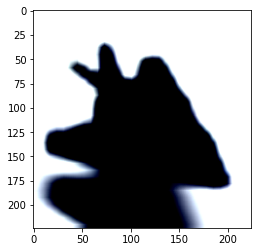

In [57]:
plt.imshow(img.permute(1,2,0))

# Device Selection

In [58]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
device = get_default_device()
device

device(type='cpu')

In [73]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Lin

# Define Helper Functions

In [100]:
def loss_batch(model, loss_func, x, y, opt = None, metric = None):
    metric_result = None 
    pred = model(x)######## ADD YOUR MODEL HERE ########
    
    loss = loss_func(pred,y)######## ADD YOUR LOSS FUNCTION HERE ########
    
    if opt is not None:
        ######## IMPLEMENT YOUR OPTIMIZATION AND BACKPROB CODE HERE ########
        loss.backward()
        opt.step()
        opt.zero_grad()
    if metric is not None:
        
        metric_result = metric(pred, y)
        
    return loss.item(), len(x), metric_result

# Add your evaluation function here

1. Add loss_batch with x and y in list results
2. calcualte the average loss by using losses and nums of samples
3. calculate the average metrics by using metrics and nums of samples 

In [102]:
def evaluate(model, loss_fn, val_dl, metric = None):
    
    with torch.no_grad():
        
        results = [loss_batch(model,loss_fn,x,y,metric= metric) for x,y in val_dl] ###### ADD YOUR CODE HERE ########
        losses, nums, metrics = zip(*results)
        avg_metric = None
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses,nums))/total###### ADD YOUR CODE HERE ########        
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics,nums))/total###### ADD YOUR CODE HERE ########
            
    return avg_loss, total, avg_metric

We have defined Scheduler to handle Learning rate, as with SGD, we would be looking for Learning rate that changes based on Accuracy
If Model finds no change in Accuracy, it will reduce learning rate by factor of 0.1. Controling parameter would be validation accuracy.

In [120]:
def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = None, metric = None, scheduler = None, scheduler_on = 'val_metric'):
    
    train_losses, val_losses, val_metrics = [], [], []
    
    
    for epoch in range(epochs):
        ########## ADD YOUR CODE HERE ##############
        for x,y in train_dl:
            train_loss,_,_ = loss_batch(model,loss_fn,x,y,opt_fn)
        
        results = evaluate(model,loss_fn,val_dl,metric) 
        val_loss,_,val_metric = results
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        ########## END YOUR CODE HERE ##############
        
            
    return train_losses, val_losses, val_metrics

Function to find accuracy, as there is no built in function in Pytorh to find accuracy, its simple code to define accuracy as below

In [103]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    
    return torch.sum(preds == labels).item() / len(preds)

Lets verify initial guess on validation

In [104]:
loss_fn =  nn.CrossEntropyLoss() ######## ADD YOUR CODE HERE ########
val_loss, _, val_acc = evaluate(model, loss_fn, val_dl, metric = accuracy)

print(val_loss, val_acc)

2.3025185913085937 0.1


# Train Model

In [118]:
num_epochs = 2 ######## ADD YOUR CODE HERE ########

optimizer = torch.optim.SGD(model.parameters(),lr=0.5)######## ADD YOUR CODE HERE ########
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'max', verbose = True)


In [ ]:
history = fit(num_epochs, model, loss_fn, train_dl, val_dl, optimizer, accuracy, scheduler, 'val_metric')

Accuracy of AlexNet model on validation set is: 

# BONUS: PRE-TRAINING USING ResNet

use the following code: `from torchvision import datasets, models, transforms`

TASK:
1. Finetune the model using ResNet
2. Load the pretrained model and reset a final fully connected layer
3. Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

# Plotting result

Plotting Train Losses

Text(0.5, 1.0, 'Plot between Training Loss vs Epochs')

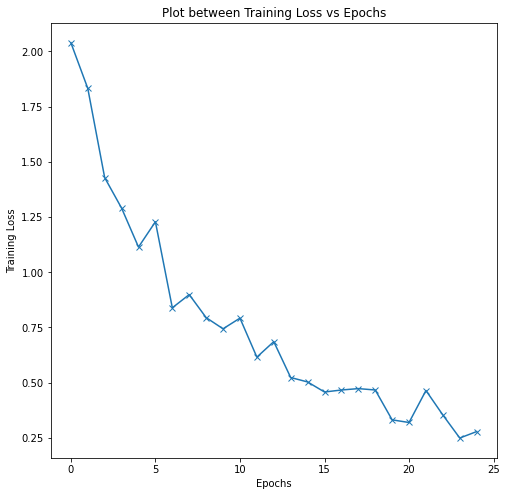

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(history[0], '-x')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Plot between Training Loss vs Epochs')

Text(0.5, 1.0, 'Plot between Validation Loss vs Epochs')

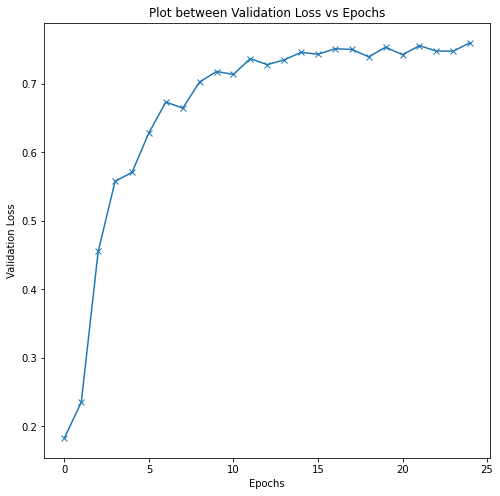

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(history[2], '-x')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss vs Epochs')